In [23]:
%matplotlib inline

import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
import scipy
import emcee

from ctisim.image import ImageSimulator, SegmentSimulator
from ctisim.utils import OverscanParameterResults, ITL_AMP_GEOM
from ctisim.core import FloatingOutputAmplifier, LinearTrap, LogisticTrap
from ctisim.fitting import OverscanFitting, SimulatedTrapModel

# ITL Full Deferred Charge Model

SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                    8 / array data type                                
NAXIS   =                    0 / number of array dimensions                     
EXTEND  =                    T                                                  
DATASEC = '[4:512,1:2000]'                                                      
NAMPS   =                   16                                                  
CHECKSUM= 'QY2RQX1PQX1PQX1P'   / HDU checksum updated 2020-01-29T13:45:00       
DATASUM = '0       '           / data unit checksum updated 2020-01-29T13:45:00  



Text(0.5, 0, 'Signal [e-]')

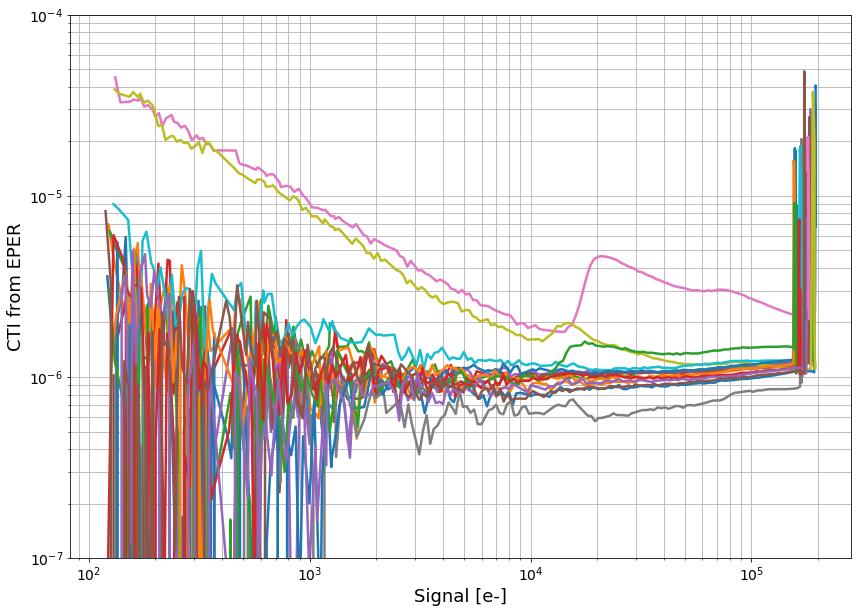

In [2]:
## Overscan results header
overscan_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_results.fits'
hdul = fits.open(overscan_results)

prihdr = hdul[0].header
print(repr(prihdr), '\n')

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

amp = 7
for amp in range(1, 17):
    data = hdul[amp].data
    signal_all = data['FLATFIELD_SIGNAL']
    indices = np.argsort(signal_all)
    signal_data = signal_all[indices]

    last_pix = data['COLUMN_MEAN'][:, 511]
    oscan1 = data['COLUMN_MEAN'][:, 512]
    #oscan2 = data['MEANROW'][:, 513]
    oscan2 = 0
    cti_data = ((oscan1+oscan2)/(512*last_pix))[indices]
      
    ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

In [3]:
amp_fit_results = '/nfs/slac/g/ki/ki19/lsst/snyder18/LSST/Data/BOT/6790D_linearity/R20/S02/R20_S02_overscan_fit_results.fits'
hdul = fits.open(amp_fit_results)

decay_times = hdul[1].data['DECAY_TIME']
drift_scales = hdul[1].data['DRIFT_SIZE']

amp = 7
output_amplifier = FloatingOutputAmplifier(1.0, drift_scales[amp-1]/10000., decay_times[amp-1], noise=0.0, offset=0.0)
print(output_amplifier.scale, output_amplifier.decay_time)

0.00015482474565505983 2.2577844


Text(0.5, 0, 'Signal [e-]')

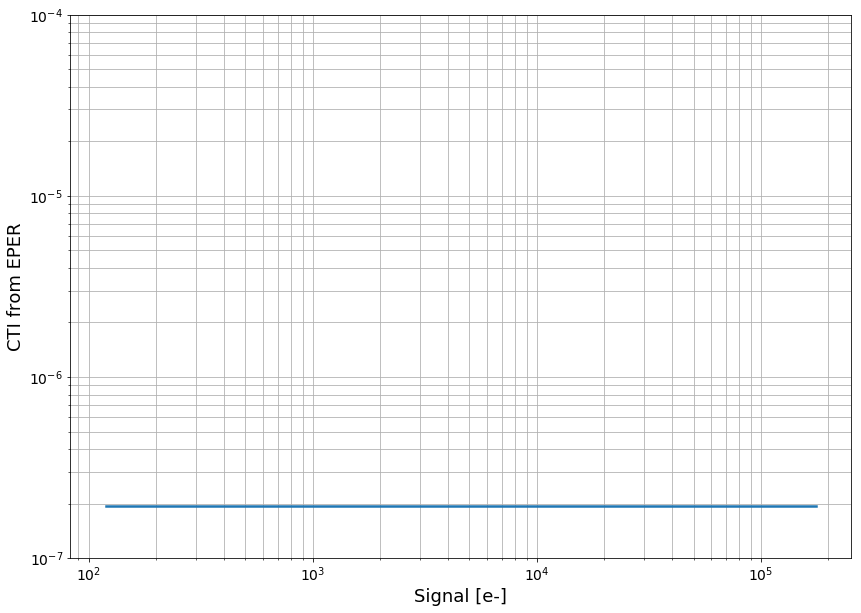

In [4]:
imarr = np.zeros((signal_data.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier)
ramp.ramp_exp(signal_data)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = 0
cti_data = ((oscan1+oscan2)/(512*last_pix))

    
ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)



XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   28 / length of dimension 1                          
NAXIS2  =                   16 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'CTI     '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'DRIFT_SIZE'                                                          
TFORM2  = 'E       '                                                            
TTYPE3  = 'DRIFT_TAU'       

Text(0.5, 0, 'Signal [e-]')

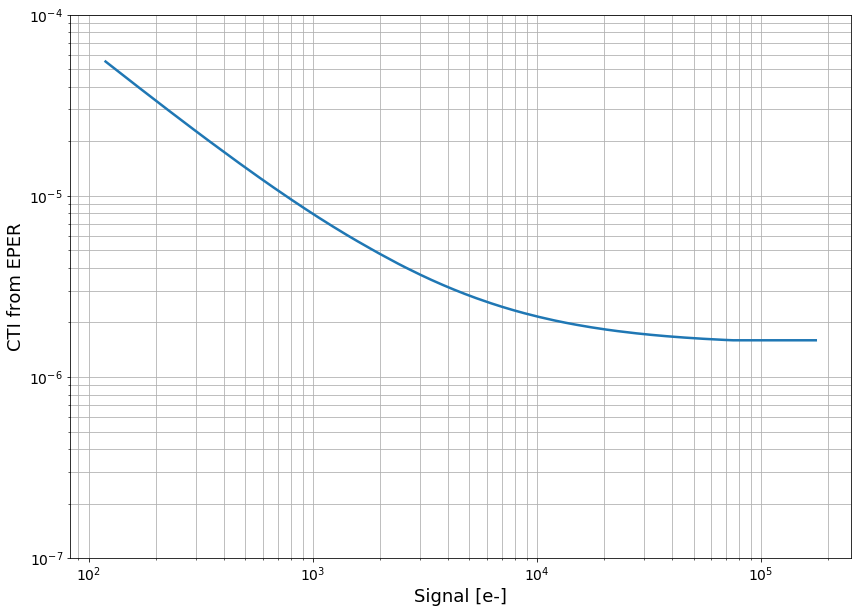

In [47]:
## Low signal trapping
mcmc_results = fits.open('../examples/data/ITL_overscan_mcmc_results.fits')
mcmc_data = mcmc_results[1].data

print(repr(mcmc_results[1].header))

## Trap parameters
amp=7
cti = mcmc_data['CTI'][amp-1]
size = mcmc_data['TRAP_SIZE'][amp-1]
emission_time = mcmc_data['TRAP_TAU'][amp-1]
scaling = mcmc_data['TRAP_DFACTOR'][amp-1]
lowsignal_trap = LinearTrap(size, emission_time, 1, scaling)
print(emission_time)

## Make CTI curve
imarr = np.zeros((signal_data.shape[0], ITL_AMP_GEOM.nx))
ramp = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, traps=low_trap)
ramp.ramp_exp(signal_data)

segarr = ramp.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width,
                               parallel_overscan_width=0)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))
last_pix = segarr[:, 511]
oscan1 = segarr[:, 512]
oscan2 = 0
cti_data = ((oscan1+oscan2)/(512*last_pix))

ax.plot(signal_data, cti_data, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

Text(0.5, 0, 'Signal [e-]')

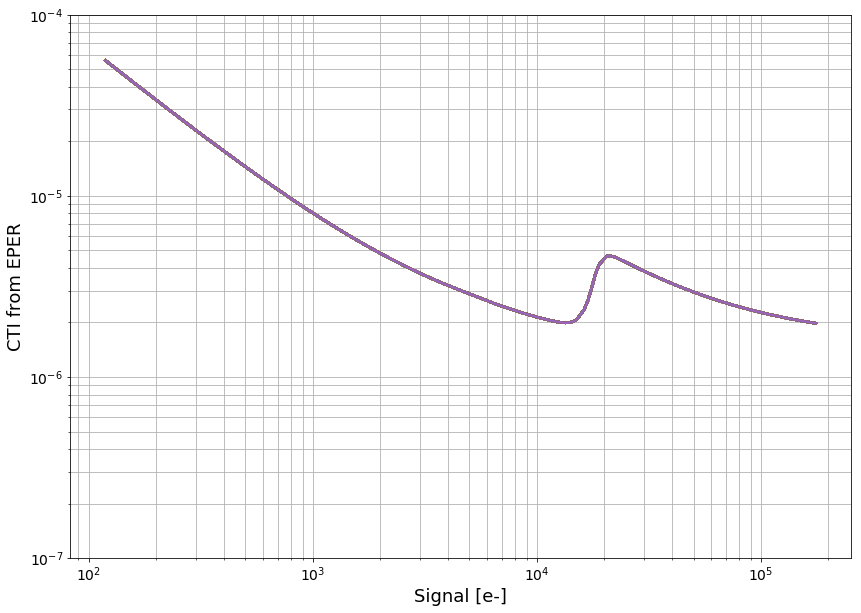

In [56]:
midsignal_trap = LogisticTrap(40, 0.5, 1, 18000., 0.0010)

x = np.array(np.meshgrid([38., 40., 42.],
                         [0.45, 0.5, 0.55],
                         [17000, 17500, 18000, 18500, 19000],
                         [0.0009, 0.001, 0.0011])).T.reshape(-1, 4)

fig, ax = plt.subplots(1, 1, figsize=(14, 10))

for i in range(x.shape[0]):
    
    trapsize, emission_time, f0, k = x[i, :]
    mid_trap = LogisticTrap(trapsize, emission_time, 1, f0, k)
    
    imarr = np.zeros((len(signal_data), ITL_AMP_GEOM.nx))
    flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, 
                        traps=[lowsignal_trap, midsignal_trap])
    flat.ramp_exp(signal_data)

    im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=True)

    last_pix = im[:, 511]
    oscan1 = im[:, 512]
    cti_model = (oscan1)/(512*last_pix)

    ax.plot(signal_data, cti_model, linewidth=2.5)
    
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-4)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)

# Example Amplifier

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                   28 / length of dimension 1                          
NAXIS2  =                   16 / length of dimension 2                          
PCOUNT  =                    0 / number of group parameters                     
GCOUNT  =                    1 / number of groups                               
TFIELDS =                    7 / number of table fields                         
TTYPE1  = 'CTI     '                                                            
TFORM1  = 'E       '                                                            
TTYPE2  = 'DRIFT_SIZE'                                                          
TFORM2  = 'E       '                                                            
TTYPE3  = 'DRIFT_TAU'       

Text(0.5, 0, 'Signal [e-]')

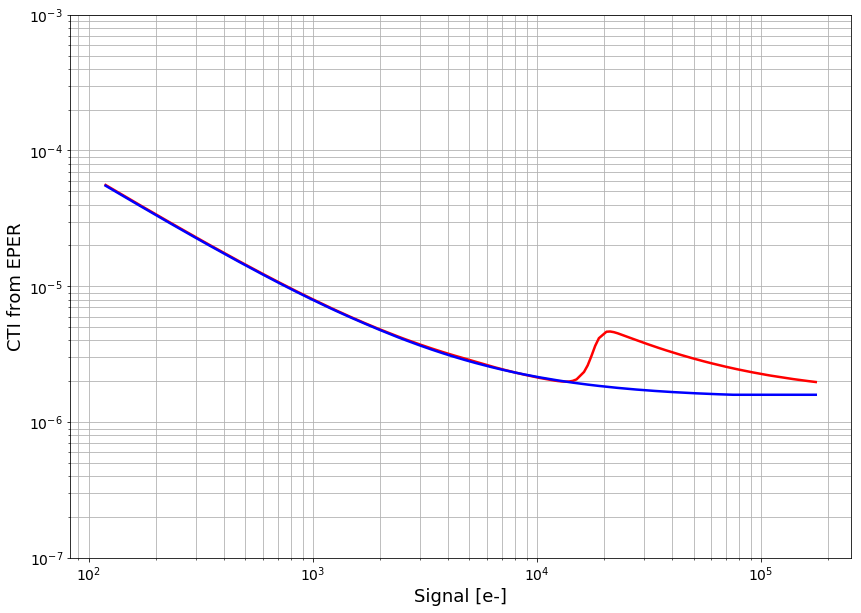

In [37]:
## Low signal trapping
mcmc_results = fits.open('../examples/data/ITL_overscan_mcmc_results.fits')
mcmc_data = mcmc_results[1].data

print(repr(mcmc_results[1].header))

## Trap parameters
amp=7
cti = mcmc_data['CTI'][amp-1]
size = mcmc_data['TRAP_SIZE'][amp-1]
emission_time = mcmc_data['TRAP_TAU'][amp-1]
scaling = mcmc_data['TRAP_DFACTOR'][amp-1]
lowsignal_trap = LinearTrap(size, emission_time, 1, scaling)
print(emission_time)

## Bias hysteresis parameters
drift_scale = mcmc_data['DRIFT_SIZE'][amp-1]
decay_time = mcmc_data['DRIFT_TAU'][amp-1]
threshold = mcmc_data['DRIFT_THRESHOLD'][amp-1]
output_amplifier = FloatingOutputAmplifier(1.0, drift_scale, decay_time, noise=0.0, offset=0.0)
midsignal_trap = LogisticTrap(40, 0.5, 1, 18000., 0.0010)

imarr = np.zeros((len(signal_data), ITL_AMP_GEOM.nx))
flat = SegmentSimulator(imarr, ITL_AMP_GEOM.prescan_width, output_amplifier, cti=cti, 
                        traps=[lowsignal_trap, midsignal_trap])
print(cti, size, emission_time, scaling)
flat.ramp_exp(signal_data)


im = flat.simulate_readout(serial_overscan_width=ITL_AMP_GEOM.serial_overscan_width, 
                           parallel_overscan_width=0,
                           do_bias_drift=True)

last_pix = im[:, 511]
oscan1 = im[:, 512]
cti_model = (oscan1)/(512*last_pix)
      
fig, ax = plt.subplots(1, 1, figsize=(14, 10))
ax.plot(signal_data, cti_model, linewidth=2.5, color='red')
ax.plot(signal_data, cti_data, linewidth=2.5, color='blue')

ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1.E-7, 1.E-3)
ax.tick_params(axis='both', which='major', labelsize=14)
ax.grid(which='both')
ax.set_ylabel('CTI from EPER', fontsize=18)
ax.set_xlabel('Signal [e-]', fontsize=18)